# I. Importing libraries and dataset 

In [26]:
import pandas as pd    
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import pickle
from sklearn import linear_model
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [27]:
loan_data_inputs_test = pd.read_csv('X_test.csv', index_col = 0)
loan_data_targets_test = pd.read_csv('y_test.csv', index_col = 0)

In [28]:
loaded_model = pickle.load(open('pd_model.sav', 'rb'))  

In [29]:
feature_list = pickle.load(open('feature_list', 'rb'))
ref_categories = pickle.load(open('ref_categories', 'rb'))

# II. Out-of-sample validation 

In [30]:
inputs_test_with_ref_cat = loan_data_inputs_test.loc[: , feature_list]

In [31]:
pd.options.display.max_rows = None

In [32]:
inputs_test = inputs_test_with_ref_cat.drop(ref_categories, axis = 1)
inputs_test.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NV_FL_HI_AL,addr_state:NM_VA,...,mths_since_last_record:Missing,mths_since_last_record:2.42-38.72,mths_since_last_record:38.72-48.4,mths_since_last_record:48.4-62.92,mths_since_last_record:62.92-65.34,mths_since_last_record:65.34-77.44,mths_since_last_record:77.44-82.28,mths_since_last_record:82.28-94.38,mths_since_last_record:94.38-106.48,mths_since_last_record:>106.48
362514,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
288564,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
213591,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
263083,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
165001,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [33]:
y_hat_test = loaded_model.model.predict(inputs_test)

In [34]:
y_hat_test_proba = loaded_model.model.predict_proba(inputs_test)
# y_hat_test_proba

In [35]:
y_hat_test_proba = y_hat_test_proba[: ][: , 1]
y_hat_test_proba

array([0.92374894, 0.84439152, 0.87583998, ..., 0.96878815, 0.95560428,
       0.94755077])

In [36]:
loan_data_targets_test_temp = loan_data_targets_test
loan_data_targets_test_temp.reset_index(drop = True, inplace = True)
df_actual_predicted_probs = pd.concat([loan_data_targets_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
df_actual_predicted_probs.columns = ['loan_data_targets_test', 'y_hat_test_proba']
df_actual_predicted_probs.index = loan_data_inputs_test.index
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba
362514,1,0.923749
288564,1,0.844392
213591,1,0.875840
263083,1,0.939602
165001,1,0.964845


## 1. Accuracy 

In [ ]:
# threshold = 0.9 
tr = 0.9
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)

Confusion matrix

In [38]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
           rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,7384,2806
1,36107,46960


In [39]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
           rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.079179,0.030089
1,0.387177,0.503555


Accuracy

In [40]:
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
           rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'],
           rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.582733735805355

Overall, accuracy is not the universal measure for a PD model. The rates of the true positive predictions goods that are being correctly classified as goods and the false positive predictions bads that are incorrectly classified as goods are far more important than the overall accuracy.

## 2. Area under the Curve (AUROC)

In [41]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'],
                                 df_actual_predicted_probs['y_hat_test_proba'])

Text(0.5, 1.0, 'ROC curve')

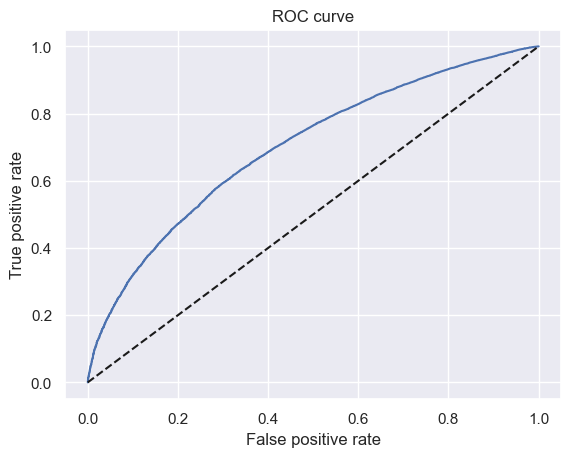

In [42]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [43]:
AUROC = roc_auc_score(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
AUROC

0.6997512353702255

AUROC of 60–70% reflects fair model performance.

## 3. Gini 

In [44]:
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
df_actual_predicted_probs.head()

,loan_data_targets_test,y_hat_test_proba,y_hat_test
11359,0,0.445304,0
35448,1,0.484718,0
10876,0,0.485872,0
210472,0,0.487112,0
11208,0,0.507377,0


In [45]:
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test
0,11359,0,0.445304,0
1,35448,1,0.484718,0
2,10876,0,0.485872,0
3,210472,0,0.487112,0
4,11208,0,0.507377,0


In [46]:
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['loan_data_targets_test'].cumsum()
df_actual_predicted_probs['Cumulative N Bad'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['loan_data_targets_test'].cumsum()
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (df_actual_predicted_probs.shape[0])
df_actual_predicted_probs['Cumulative Perc Good'] = df_actual_predicted_probs['Cumulative N Good'] / df_actual_predicted_probs['loan_data_targets_test'].sum()
df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['loan_data_targets_test'].sum())
df_actual_predicted_probs.head()

,index,loan_data_targets_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
0,11359,0,0.445304,0,1,0,1,0.000011,0.000000,0.000098
1,35448,1,0.484718,0,2,1,1,0.000021,0.000012,0.000098
2,10876,0,0.485872,0,3,1,2,0.000032,0.000012,0.000196
3,210472,0,0.487112,0,4,1,3,0.000043,0.000012,0.000294
4,11208,0,0.507377,0,5,1,4,0.000054,0.000012,0.000393


Text(0.5, 1.0, 'Gini')

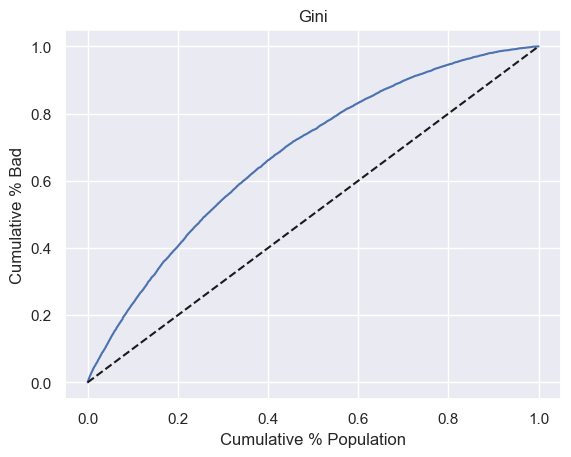

In [47]:
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Bad'])
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Population'], linestyle = '--', color = 'k')
plt.xlabel('Cumulative % Population')
plt.ylabel('Cumulative % Bad')
plt.title('Gini')

In [48]:
Gini = AUROC * 2 - 1
Gini

0.3995024707404511

This Gini level indicates a fair model.

## 4. Kolmogorov-Smirnov (KS)

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

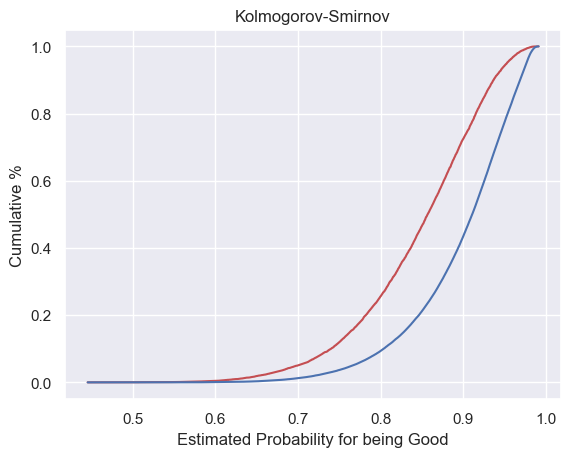

In [49]:
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color = 'r')
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color = 'b')
plt.xlabel('Estimated Probability for being Good')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov')

In [50]:
KS = max(df_actual_predicted_probs['Cumulative Perc Bad'] - df_actual_predicted_probs['Cumulative Perc Good'])
KS

0.2943211524641193

Again, this KS level indicates that the model has fair discriminatory power.